In [1]:
%load_ext lab_black

In [2]:
%config Completer.use_jedi = False

In [579]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time
from tqdm.notebook import tqdm

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
)

from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor, XGBRegressor
from ngboost import NGBRegressor

In [580]:
X = pd.DataFrame(load_boston()["data"], columns=load_boston()["feature_names"])
y = pd.Series(load_boston()["target"])

In [581]:
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [598]:
# create a list of base-models
def get_models():
    models = list()
    models.append(AdaBoostRegressor())
    models.append(GradientBoostingRegressor())
    models.append(RandomForestRegressor())
    models.append(ExtraTreesRegressor())
    models.append(LGBMRegressor())
    models.append(XGBRegressor())
    models.append(XGBRFRegressor())

    return models

In [599]:
def get_oof_pred(X, y, cv, models):
    meta_X = pd.DataFrame()

    for i, model in tqdm(enumerate(models), total=len(models)):

        oof_pred = np.zeros_like(y)

        for j, (train_idx, valid_idx) in tqdm(enumerate(cv), total=len(cv)):
            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]

            model.fit(X_train, y_train)

            y_pred = model.predict(X_valid)
            oof_pred[valid_idx] = y_pred

        meta_X[f"{model.__class__.__name__}"] = oof_pred
        print(
            f"{model.__class__.__name__} Out of Fold RMSE: {rmse_score(y, oof_pred):.3f}\tR2: {r2_score(y, oof_pred):.3f}"
        )

    return meta_X.add_suffix("_oof")

In [600]:
def fit_base_models(X, y, models):
    for model in tqdm(models, total=len(models)):
        print("Fitting", model.__class__.__name__, "is done")
        model.fit(X, y)

In [681]:
np.append(meta_model.coef_, meta_model.intercept_)

array([-0.10416654,  0.14025199, -0.32022607,  0.77459095,  0.21355855,
        0.28238713,  0.01346033,  0.02001236])

In [696]:
def fit_meta_model(X, y):
    model = ElasticNet(fit_intercept=True, max_iter=10_000)
    #     model = BayesianRidge()
    model.fit(X, y)

    output_df = pd.DataFrame(
        np.append(model.coef_, model.intercept_),
        index=[f"{model.__class__.__name__}" for model in models] + ["Intercept"],
        columns=["coef"],
    )

    display(output_df)
    return model

In [697]:
def evaluate_models(X, y, models):
    for model in tqdm(models, total=len(models)):
        y_pred = model.predict(X)
        rmse = rmse_score(y, y_pred)
        r2 = r2_score(y, y_pred)
        print(f"{model.__class__.__name__}: RMSE {rmse:.3f}\tR2: {r2:.3f}")

In [698]:
def super_learner_predict(X, models, meta_model):
    meta_X = pd.DataFrame()
    for i, model in tqdm(enumerate(models), total=len(models)):
        meta_X[f"{model.__class__.__name__}"] = model.predict(X)
    return meta_X, meta_model.predict(meta_X)

In [700]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
cv = list(KFold(n_splits=10, shuffle=True).split(X_train))

models = get_models()

In [701]:
meta_X = get_oof_pred(X_train.values, y_train.values, cv, models)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

AdaBoostRegressor Out of Fold RMSE: 4.192	R2: 0.794


  0%|          | 0/10 [00:00<?, ?it/s]

GradientBoostingRegressor Out of Fold RMSE: 3.438	R2: 0.861


  0%|          | 0/10 [00:00<?, ?it/s]

RandomForestRegressor Out of Fold RMSE: 3.528	R2: 0.854


  0%|          | 0/10 [00:00<?, ?it/s]

ExtraTreesRegressor Out of Fold RMSE: 3.347	R2: 0.869


  0%|          | 0/10 [00:00<?, ?it/s]

LGBMRegressor Out of Fold RMSE: 3.653	R2: 0.844


  0%|          | 0/10 [00:00<?, ?it/s]

XGBRegressor Out of Fold RMSE: 3.326	R2: 0.870


  0%|          | 0/10 [00:00<?, ?it/s]

XGBRFRegressor Out of Fold RMSE: 3.659	R2: 0.843


In [702]:
meta_X.corr()

,AdaBoostRegressor_oof,GradientBoostingRegressor_oof,RandomForestRegressor_oof,ExtraTreesRegressor_oof,LGBMRegressor_oof,XGBRegressor_oof,XGBRFRegressor_oof
AdaBoostRegressor_oof,1.000000,0.971843,0.973608,0.970099,0.962547,0.957766,0.975863
GradientBoostingRegressor_oof,0.971843,1.000000,0.988500,0.984956,0.979550,0.982522,0.986825
RandomForestRegressor_oof,0.973608,0.988500,1.000000,0.989977,0.978149,0.980795,0.995808
ExtraTreesRegressor_oof,0.970099,0.984956,0.989977,1.000000,0.979758,0.981016,0.987140
LGBMRegressor_oof,0.962547,0.979550,0.978149,0.979758,1.000000,0.972890,0.976278
XGBRegressor_oof,0.957766,0.982522,0.980795,0.981016,0.972890,1.000000,0.976437
XGBRFRegressor_oof,0.975863,0.986825,0.995808,0.987140,0.976278,0.976437,1.000000


In [703]:
fit_base_models(X_train.values, y_train.values, models)

  0%|          | 0/7 [00:00<?, ?it/s]

Fitting AdaBoostRegressor is done
Fitting GradientBoostingRegressor is done
Fitting RandomForestRegressor is done
Fitting ExtraTreesRegressor is done
Fitting LGBMRegressor is done
Fitting XGBRegressor is done
Fitting XGBRFRegressor is done


In [704]:
evaluate_models(X_train.values, y_train.values, models)

  0%|          | 0/7 [00:00<?, ?it/s]

AdaBoostRegressor: RMSE 2.893	R2: 0.902
GradientBoostingRegressor: RMSE 1.324	R2: 0.979
RandomForestRegressor: RMSE 1.275	R2: 0.981
ExtraTreesRegressor: RMSE 0.000	R2: 1.000
LGBMRegressor: RMSE 1.402	R2: 0.977
XGBRegressor: RMSE 0.018	R2: 1.000
XGBRFRegressor: RMSE 1.811	R2: 0.962


In [705]:
evaluate_models(X_test.values, y_test.values, models)

  0%|          | 0/7 [00:00<?, ?it/s]

AdaBoostRegressor: RMSE 2.985	R2: 0.890
GradientBoostingRegressor: RMSE 2.879	R2: 0.897
RandomForestRegressor: RMSE 2.713	R2: 0.909
ExtraTreesRegressor: RMSE 2.804	R2: 0.903
LGBMRegressor: RMSE 3.072	R2: 0.883
XGBRegressor: RMSE 2.914	R2: 0.895
XGBRFRegressor: RMSE 2.896	R2: 0.896


In [709]:
meta_model = fit_meta_model(meta_X.values, y_train.values)

# print(meta_model.coef_, meta_model.intercept_)

,coef
AdaBoostRegressor,-0.000000
GradientBoostingRegressor,0.161140
RandomForestRegressor,0.000000
ExtraTreesRegressor,0.403546
LGBMRegressor,0.008802
XGBRegressor,0.436988
XGBRFRegressor,0.000000
Intercept,-0.202844


In [710]:
meta_X_val, y_pred = super_learner_predict(X_test.values, models, meta_model)

  0%|          | 0/7 [00:00<?, ?it/s]

In [711]:
print(f"Super Learner: RMSE {rmse_score(y_test, y_pred):.3f}")
print(f"Super Learner: R2 {r2_score(y_test, y_pred):.3f}")

Super Learner: RMSE 2.705
Super Learner: R2 0.909


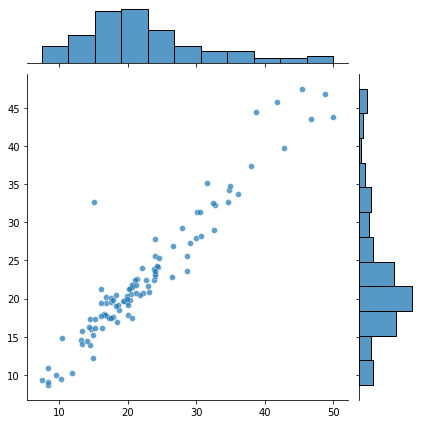

In [712]:
sns.jointplot(x=y_test, y=y_pred, joint_kws={"alpha": 0.7})

In [713]:
y_pred = np.array([model.predict(X_test.values) for model in models[1:]])

y_pred = np.mean(y_pred, axis=0)

print(f"Super Learner: RMSE {rmse_score(y_test, y_pred):.3f}")
print(f"Super Learner: R2 {r2_score(y_test, y_pred):.3f}")

Super Learner: RMSE 2.670
Super Learner: R2 0.912


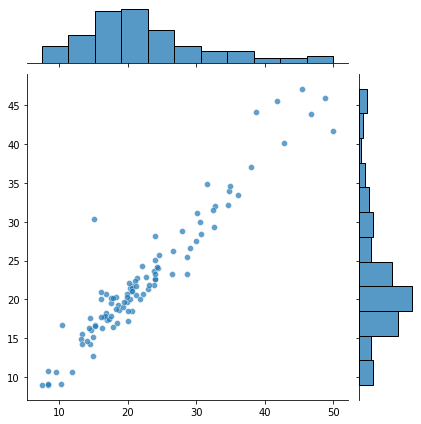

In [714]:
sns.jointplot(x=y_test, y=y_pred, joint_kws={"alpha": 0.7})